In [24]:
import folium
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio as rio
from shapely.geometry import Point, Polygon
import calendar
from branca.element import Template, MacroElement

from folium.plugins import HeatMapWithTime


# Load gray whale data
df = pd.read_csv('obis_seamap_species_180521_points.csv', encoding = 'ISO-8859-1')


df['date_time'] = pd.to_datetime(df['date_time'])
df['month'] = df['date_time'].dt.month.apply(lambda x: calendar.month_name[x])
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)




In [25]:
#Change dates to same year and sort
gdf['date_time'] = gdf['date_time'].dt.strftime('2023-%m-15')  # Convert Timestamp to string
gdf = gdf.sort_values('date_time')

#Prepare heat map data
gdf['heat_data'] = pd.Series([xy for xy in zip(gdf['latitude'], gdf['longitude'])])
gdf = gdf[['heat_data', 'month']]
gdf['heat_data'] = list(gdf['heat_data'])

#Group by month
gdf = gdf.groupby('month')['heat_data'].apply(list).reset_index()

#Sort by month
gdf['month'] = pd.to_datetime(gdf['month'], format='%B', errors='coerce').dt.month
gdf = gdf.sort_values('month')
gdf['month'] = pd.to_datetime(gdf['month'], format='%m').dt.strftime('%B')

#Making data a list within a list within a list
data = gdf['heat_data'].to_list()
data = [[list(t) for t in lst] for lst in data]
index = gdf['month'].to_list()






In [26]:
# Create a map centered on the Pacific Ocean

m = folium.Map(location=[52.54161130191102, -135.07705075680246], 
               zoom_start=3, 
               tiles = 'https://tile.thunderforest.com/transport-dark/{z}/{x}/{y}.png?apikey=da2b917cea704ac4b794ec51f416f71e',
               attr= '&copy; <a href="http://www.thunderforest.com/">Thunderforest</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors'
               )

#Create Heat Map with Time layer
HeatMapWithTime(data=data, 
                index=index,
                gradient={0.1: 'blue', 0.25: 'green', 0.5: 'yellow', 0.75: 'orange', 1: 'red'},
                #auto_play=True
                name='Heat Map'
                
                ).add_to(m)




In [27]:
# Create layer for reroute recomendations 
line_layer = folium.FeatureGroup(name='Reroute', show=False)

#LA
LAcoordinates1 = [(33.6006,-118.3662),(33.65141,-120.55210)]
LAline1 = folium.PolyLine(locations=LAcoordinates1,weight=3,color='orange').add_to(line_layer)
LAcoordinates2 = [(33.65141,-120.55210),(34.4513,-121.1281)]
LAline2 = folium.PolyLine(locations=LAcoordinates2,weight=3,color='orange').add_to(line_layer)

#SanFran
SFcoordinates1 = [(37.7530,-122.6779),(37.4662,-123.2485)]
SFline1 = folium.PolyLine(locations=SFcoordinates1,weight=3,color='orange').add_to(line_layer)
SFcoordinates2 = [(37.4662,-123.2485),(38.5352,-123.8175)]
SFline2 = folium.PolyLine(locations=SFcoordinates2,weight=3,color='orange').add_to(line_layer)

#SanDiego
SDcoordinates1 = [(32.62383,-117.21743),(32.30286,-117.47261)]
SDline1 = folium.PolyLine(locations=SDcoordinates1,weight=3,color='orange').add_to(line_layer)

line_layer.add_to(m)





In [28]:

#add legend
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:red;opacity:0.7;'></span>Gray Whales</li>
    <li><span style='background:green;opacity:0.7;'></span>Shipping Density</li>
    

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)



# Add raster layer to the map
shippingroute = rio.open('baja_clipin.tif')
print(shippingroute.crs)
data = shippingroute.read(1, masked=True)
mask = shippingroute.dataset_mask()
data = np.ma.filled(data, -9999)
folium.raster_layers.ImageOverlay(
    image= data,
    bounds=[[21.677647937, -130.505311275], [52.042647937, -106.720311275]],
    colormap = lambda x: (0, 1, 0, x), 
    caption='Shipping Density',
    name='Shipping Density'  
).add_to(m)

m.get_root().add_child(macro)

# Add layer control to the map
folium.LayerControl().add_to(m)








EPSG:3857



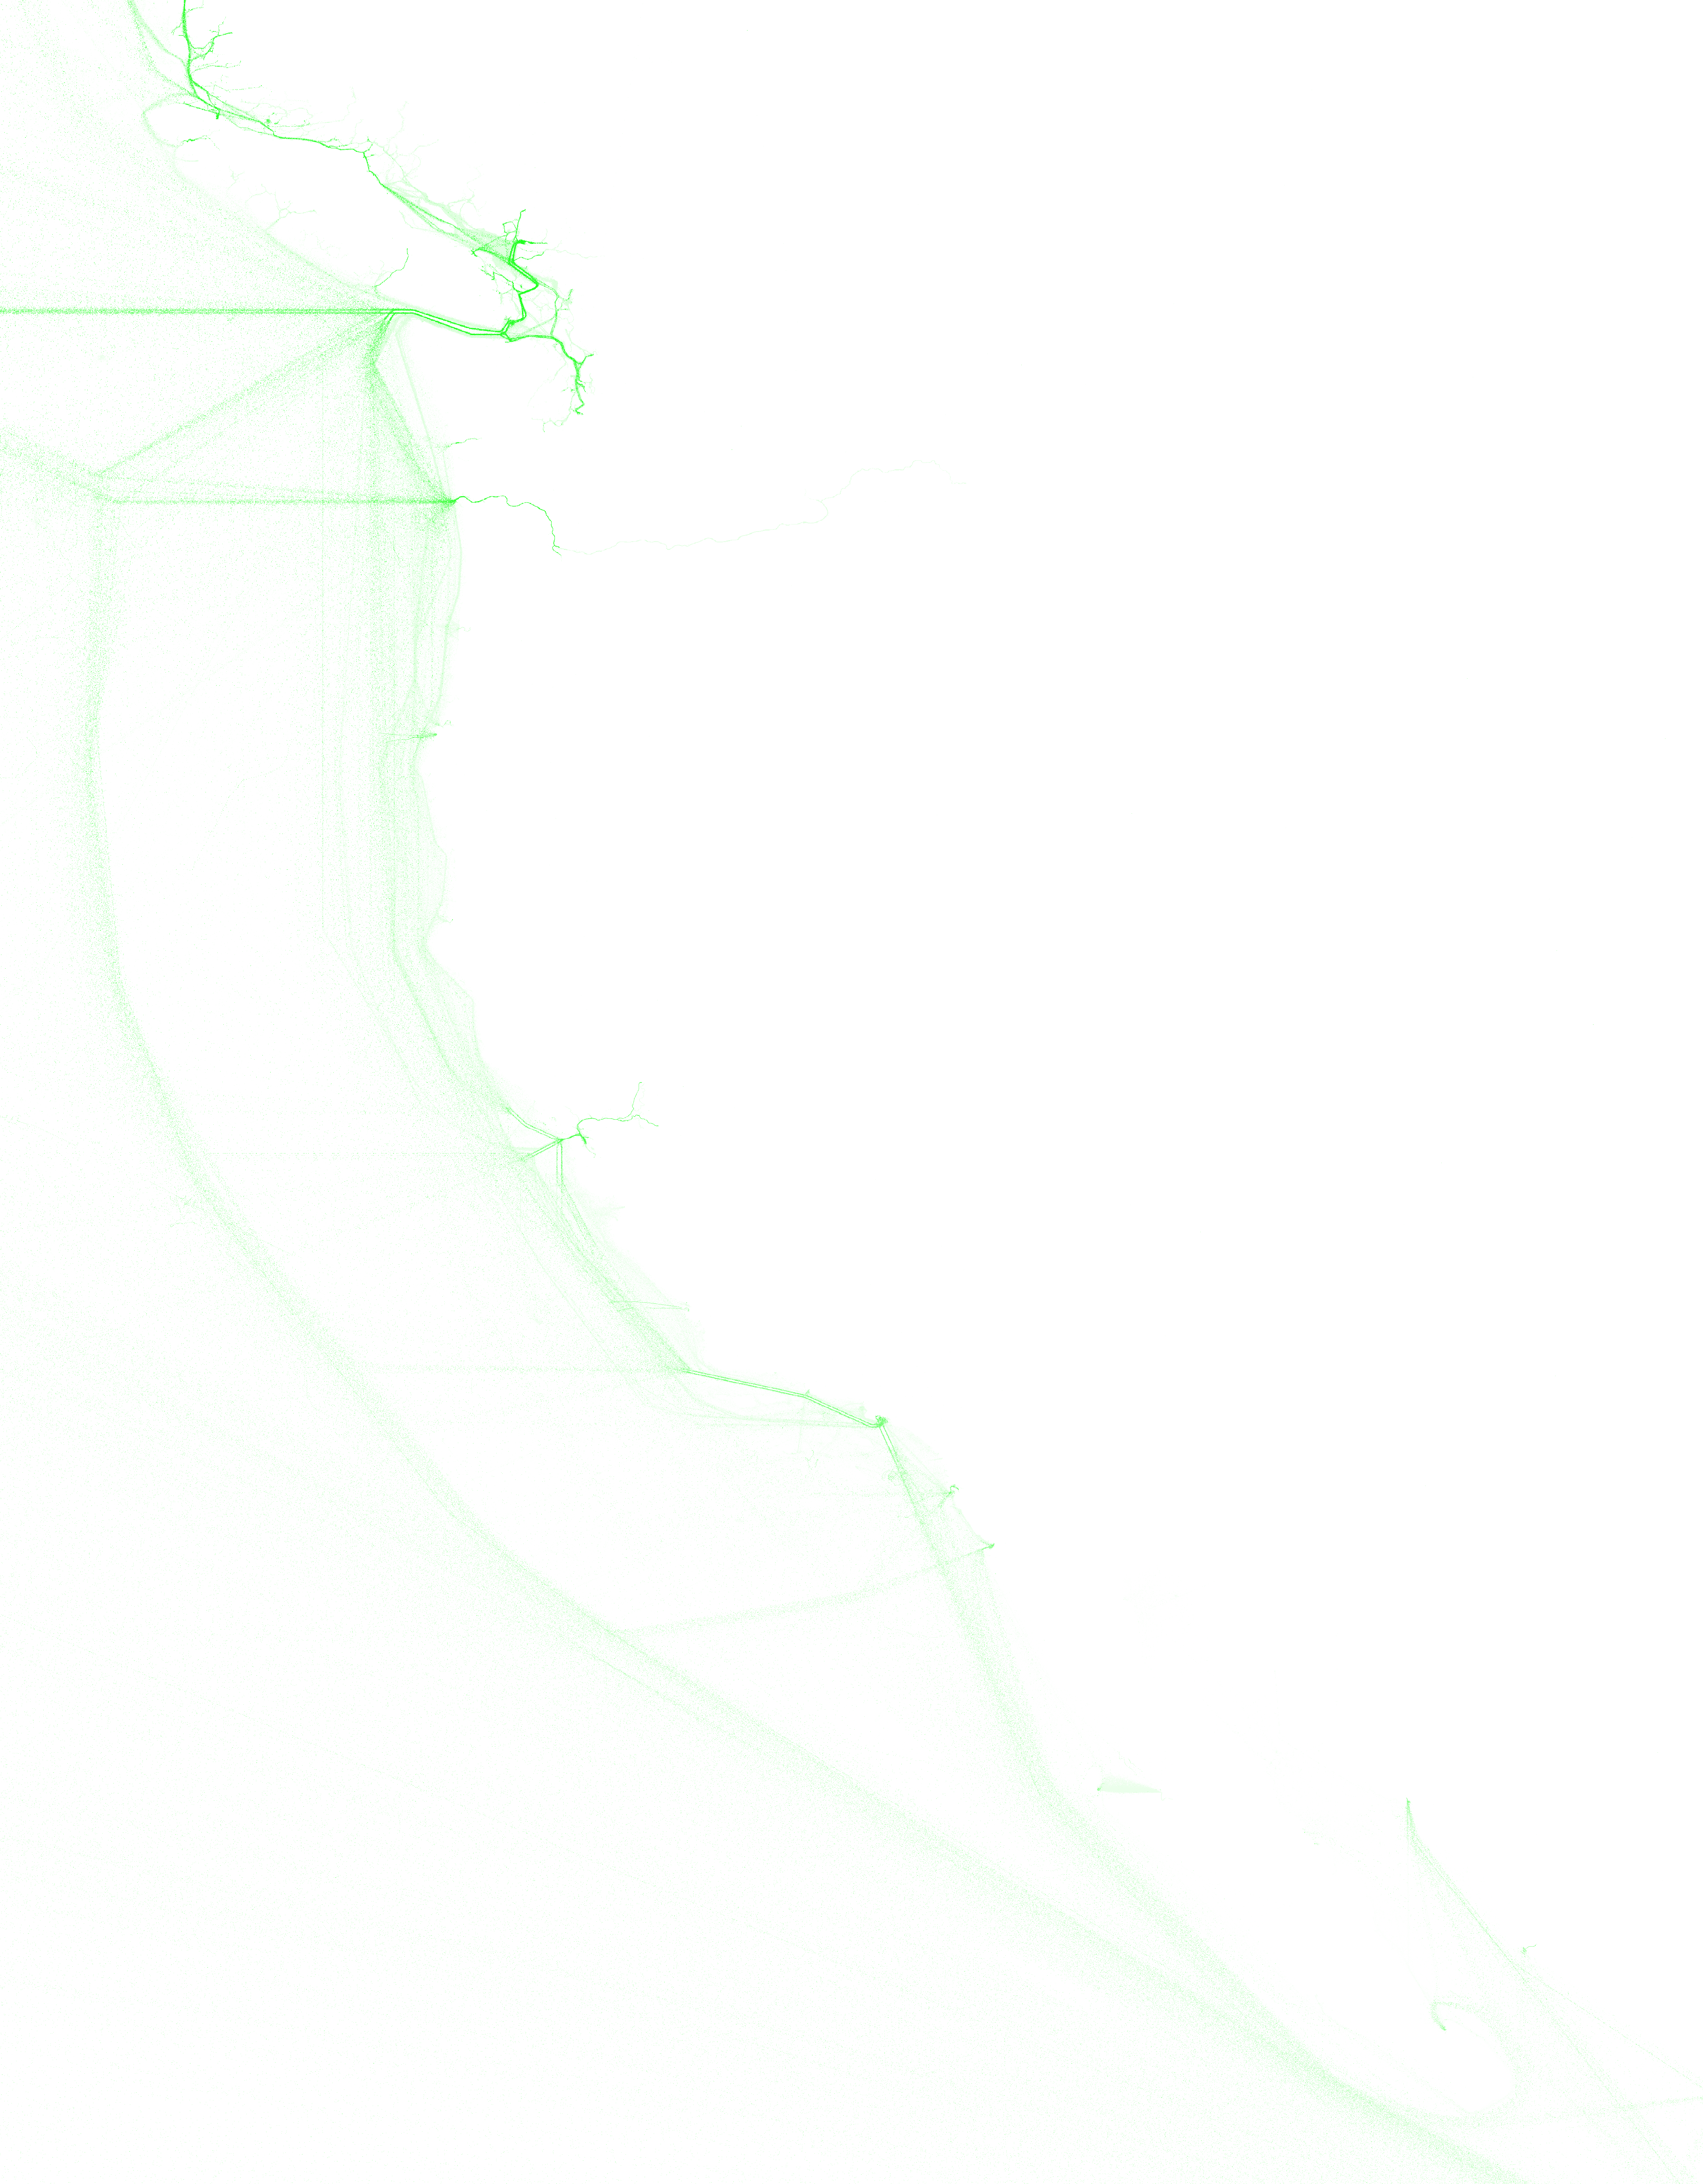

In [29]:
#display map
m

In [30]:
# Save the map as an HTML file
m.save('004_Heatmap.html')

# Open in browser to inspect
import webbrowser
webbrowser.open('004_Heatmap.html')

True